In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext
from pyspark.sql import SparkSession 
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(sc.version)
print(spark.version)

2.4.7
2.4.7


In [ ]:
def convert_csv_to_parquet(csv_file_path, parquet_file_path):
    df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
    df.write.parquet(parquet_file_path)
convert_csv_to_parquet('us-counties.csv', 'us-counties.parquet')
convert_csv_to_parquet('all_weekly_excess_deaths.csv', 'all_weekly_excess_deaths.parquet')

In [3]:
df = spark.read.parquet('us-counties.parquet')
df.printSchema()
df.show(5)

root
 |-- date: string (nullable = true)
 |-- geoid: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cases: long (nullable = true)
 |-- cases_avg: double (nullable = true)
 |-- cases_avg_per_100k: double (nullable = true)
 |-- deaths: long (nullable = true)
 |-- deaths_avg: double (nullable = true)
 |-- deaths_avg_per_100k: double (nullable = true)

+----------+---------+---------+----------+-----+---------+------------------+------+----------+-------------------+
|      date|    geoid|   county|     state|cases|cases_avg|cases_avg_per_100k|deaths|deaths_avg|deaths_avg_per_100k|
+----------+---------+---------+----------+-----+---------+------------------+------+----------+-------------------+
|2020-01-21|USA-53061|Snohomish|Washington|    1|     0.14|              0.02|     0|       0.0|                0.0|
|2020-01-22|USA-53061|Snohomish|Washington|    0|     0.14|              0.02|     0|       0.0|                0.0|
|2020-

In [3]:
df = df.withColumn('date', F.to_date(F.col('date'), 'yyyy-MM-dd'))
min_date = df.agg(F.min('date')).collect()[0][0]
max_date = df.agg(F.max('date')).collect()[0][0]
print(f'The data starts from {min_date} and ends at {max_date}.')

The data starts from 2020-01-21 and ends at 2021-09-29.


In [11]:
df_state = df.groupBy('state').agg(F.sum('cases').alias('total_cases'), F.sum('deaths').alias('total_deaths'))
df_state = df_state.withColumn('case_fatality_rate', F.col('total_deaths') / F.col('total_cases'))
df_state = df_state.orderBy(F.desc('case_fatality_rate'))
df_state.show()
df_state.write.format("mongo").mode("overwrite").option("uri", "mongodb://localhost:27018/Project").option("collection", "Project_data").save()
num_states = df_state.select('state').distinct().count()
print(f'There are {num_states} states in total.')

+--------------------+-----------+------------+--------------------+
|               state|total_cases|total_deaths|  case_fatality_rate|
+--------------------+-----------+------------+--------------------+
|          New Jersey|    1152243|       27400|0.023779706190447676|
|       Massachusetts|     810319|       18600|0.022953923084612356|
|            New York|    2419556|       55516|0.022944705557548576|
|         Connecticut|     390180|        8629|  0.0221154339023015|
|        Pennsylvania|    1425048|       29323| 0.02057685074467667|
|         Mississippi|     487293|        9588|0.019676047059982393|
|            Maryland|     531091|       10426| 0.01963128729351467|
|            Michigan|    1147980|       22336|0.019456784961410477|
|District of Columbia|      60996|        1174| 0.01924716374844252|
|          New Mexico|     251389|        4778|0.019006400439160027|
|           Louisiana|     739661|       13900|0.018792392731264727|
|             Arizona|    1090839|

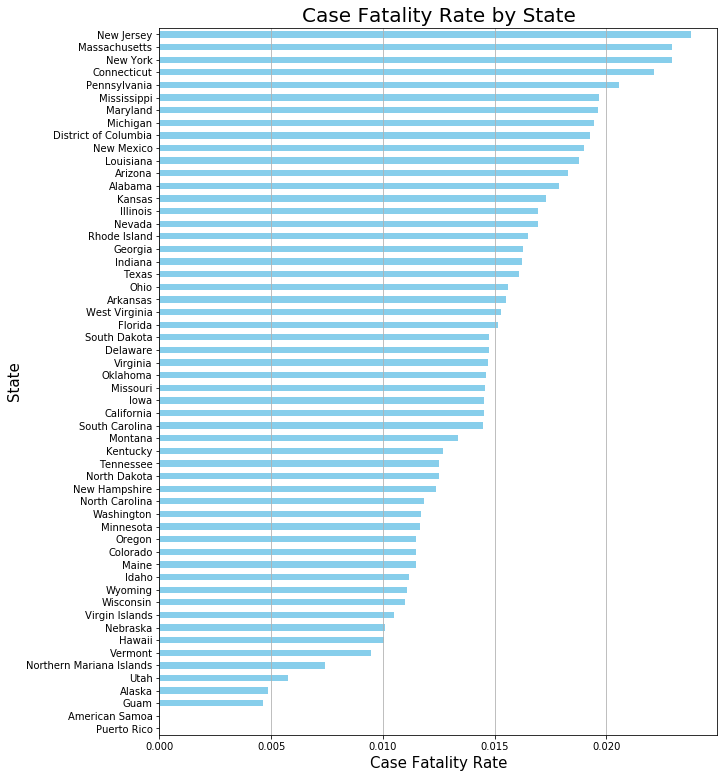

In [5]:
df_state_pd = df_state.toPandas()
df_state_pd.sort_values('case_fatality_rate', ascending=True).plot(kind='barh', x='state', y='case_fatality_rate', legend=False, color='skyblue', figsize=(10, 13))
plt.xlabel('Case Fatality Rate', fontsize=15)  
plt.ylabel('State', fontsize=15)  
plt.title('Case Fatality Rate by State', fontsize=20)  
plt.grid(axis='x')
plt.yticks(fontsize=10)
plt.show()

In [12]:
df_county_state = df.groupBy('state', 'county').agg(F.sum('cases').alias('total_cases'), F.sum('deaths').alias('total_deaths'))
df_county_state = df_county_state.withColumn('case_fatality_rate', F.col('total_deaths') / F.col('total_cases'))
df_county_state = df_county_state.orderBy(F.desc('total_cases'), F.desc('case_fatality_rate'))
df_county_state.show()
df_county_state.write.format("mongo").mode("overwrite").option("uri", "mongodb://localhost:27018/Project").option("collection", "Project_data").save()
num_counties = df_county_state.select('county').distinct().count()
print(f'There are {num_counties} counties in total.')

+----------+--------------+-----------+------------+--------------------+
|     state|        county|total_cases|total_deaths|  case_fatality_rate|
+----------+--------------+-----------+------------+--------------------+
|California|   Los Angeles|    1458381|       26078|0.017881472674150307|
|  New York| New York City|    1082099|       34245|0.031646827138736844|
|   Arizona|      Maricopa|     692629|       11435| 0.01650955995200894|
|   Florida|    Miami-Dade|     656813|        8280|0.012606327828468681|
|  Illinois|          Cook|     618610|       11584|0.018725853122322625|
|     Texas|        Harris|     554336|        8255|0.014891690238411361|
|     Texas|        Dallas|     386543|        4848| 0.01254194229361287|
|California|     San Diego|     372208|        4054|0.010891759446331084|
|California|     Riverside|     362691|        4985|0.013744482217645324|
|California|San Bernardino|     350976|        5545|0.015798801057622172|
|   Florida|       Broward|     346392

In [8]:
rdd = df_county_state.select('case_fatality_rate').rdd.flatMap(lambda x: x)
bins = np.linspace(0, 0.07, 30)
hist = rdd.histogram(bins.tolist())
for i in range(len(hist[1])):
    print(f'Bin: {hist[0][i]} - {hist[0][i + 1]}, Frequency: {hist[1][i]}')

Bin: 0.0 - 0.002413793103448276, Frequency: 149
Bin: 0.002413793103448276 - 0.004827586206896552, Frequency: 48
Bin: 0.004827586206896552 - 0.007241379310344828, Frequency: 111
Bin: 0.007241379310344828 - 0.009655172413793104, Frequency: 226
Bin: 0.009655172413793104 - 0.01206896551724138, Frequency: 357
Bin: 0.01206896551724138 - 0.014482758620689656, Frequency: 446
Bin: 0.014482758620689656 - 0.016896551724137933, Frequency: 460
Bin: 0.016896551724137933 - 0.019310344827586208, Frequency: 379
Bin: 0.019310344827586208 - 0.021724137931034483, Frequency: 277
Bin: 0.021724137931034483 - 0.02413793103448276, Frequency: 248
Bin: 0.02413793103448276 - 0.026551724137931037, Frequency: 167
Bin: 0.026551724137931037 - 0.028965517241379312, Frequency: 105
Bin: 0.028965517241379312 - 0.03137931034482759, Frequency: 98
Bin: 0.03137931034482759 - 0.033793103448275866, Frequency: 51
Bin: 0.033793103448275866 - 0.03620689655172414, Frequency: 43
Bin: 0.03620689655172414 - 0.038620689655172416, Freq

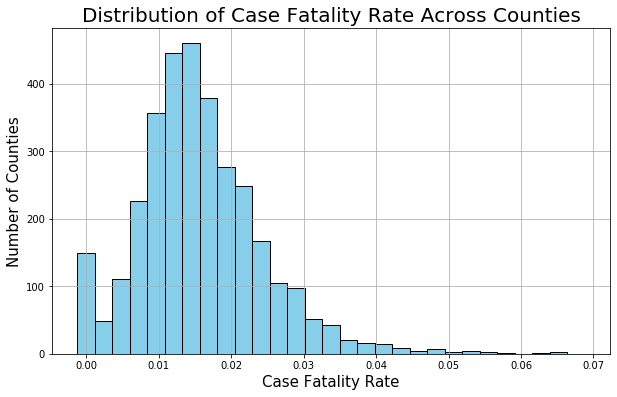

In [9]:
bins, frequencies = hist
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], frequencies, width=(bins[1]-bins[0]), edgecolor='black', color='skyblue')
plt.xlabel('Case Fatality Rate', fontsize=15)
plt.ylabel('Number of Counties', fontsize=15)
plt.title('Distribution of Case Fatality Rate Across Counties', fontsize=20)
plt.grid(True)
plt.show()

+----------+--------------+-----------+------------+--------------------+
|     state|        county|total_cases|total_deaths|  case_fatality_rate|
+----------+--------------+-----------+------------+--------------------+
|California|   Los Angeles|    1458381|       26078|0.017881472674150307|
|  New York| New York City|    1082099|       34245|0.031646827138736844|
|   Arizona|      Maricopa|     692629|       11435| 0.01650955995200894|
|   Florida|    Miami-Dade|     656813|        8280|0.012606327828468681|
|  Illinois|          Cook|     618610|       11584|0.018725853122322625|
|     Texas|        Harris|     554336|        8255|0.014891690238411361|
|     Texas|        Dallas|     386543|        4848| 0.01254194229361287|
|California|     San Diego|     372208|        4054|0.010891759446331084|
|California|     Riverside|     362691|        4985|0.013744482217645324|
|California|San Bernardino|     350976|        5545|0.015798801057622172|
+----------+--------------+-----------

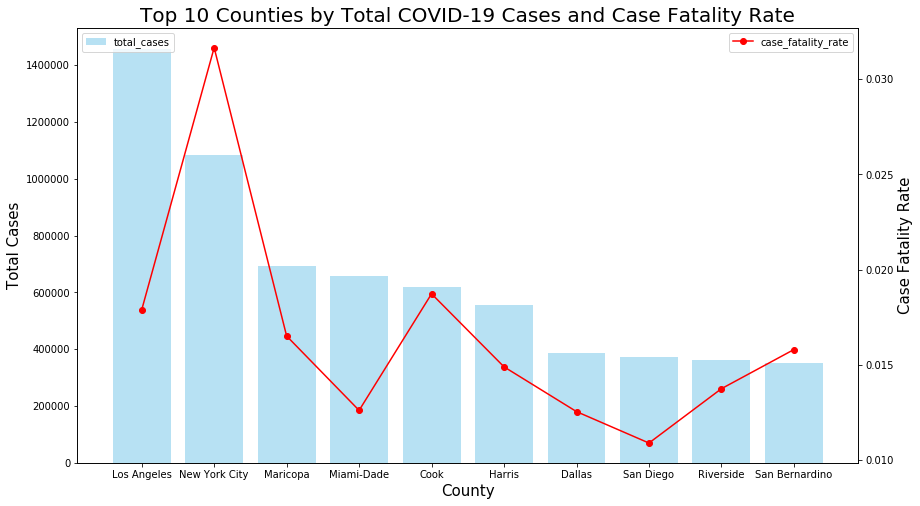

In [7]:
top_10_counties = df_county_state.orderBy(F.desc('total_cases')).limit(10)
top_10_counties.show()
top_10_counties_pd = top_10_counties.toPandas()
plt.figure(figsize=(14, 8))
bar = plt.bar(top_10_counties_pd['county'], top_10_counties_pd['total_cases'], color='skyblue', alpha=0.6, label='total_cases')
plt.xlabel('County', fontsize=15)
plt.ylabel('Total Cases', fontsize=15)
plt.legend(loc='upper left')
ax2 = plt.gca().twinx()
line, = ax2.plot(top_10_counties_pd['county'], top_10_counties_pd['case_fatality_rate'], color='red', marker='o', label='case_fatality_rate')
plt.legend(loc='upper right')
plt.title('Top 10 Counties by Total COVID-19 Cases and Case Fatality Rate', fontsize=20)
ax2.set_ylabel('Case Fatality Rate', fontsize=15)
plt.show()

In [5]:
print('Case Fatality Rates by County:')
df_county_state.select('county', 'case_fatality_rate').show()

Case Fatality Rates by County:
+--------------+--------------------+
|        county|  case_fatality_rate|
+--------------+--------------------+
|   Los Angeles|0.017881472674150307|
| New York City|0.031646827138736844|
|      Maricopa| 0.01650955995200894|
|    Miami-Dade|0.012606327828468681|
|          Cook|0.018725853122322625|
|        Harris|0.014891690238411361|
|        Dallas| 0.01254194229361287|
|     San Diego|0.010891759446331084|
|     Riverside|0.013744482217645324|
|San Bernardino|0.015798801057622172|
|       Broward|0.012708145684657845|
|       Tarrant|0.012390966454785877|
|         Clark|0.017596895585911217|
|        Orange|0.017026697962821174|
|         Bexar|0.015060279759911383|
|  Hillsborough|0.011255883464458721|
|       Suffolk|0.015306210814368353|
|        Orange| 0.00886674089563588|
|    Palm Beach| 0.01768318168665402|
|        Nassau|0.015634050252988228|
+--------------+--------------------+
only showing top 20 rows



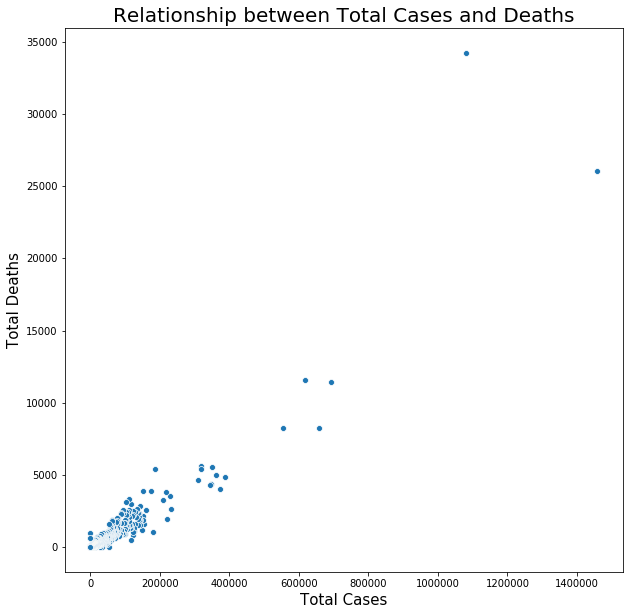

In [6]:
df_county_state_pd = df_county_state.toPandas()
plt.figure(figsize=(10, 10))
sns.scatterplot(x='total_cases', y='total_deaths', data=df_county_state_pd)
plt.title('Relationship between Total Cases and Deaths', fontsize=20)
plt.xlabel('Total Cases', fontsize=15)
plt.ylabel('Total Deaths', fontsize=15)
plt.show()

In [7]:
total_cases = df.agg(F.sum('cases')).first()[0]
total_deaths = df.agg(F.sum('deaths')).first()[0]
mortality_rate = total_deaths / total_cases
print(f'The total cases in the US is {total_cases}')
print(f'The total deaths in the US is {total_deaths}')
print(f'The total mortality rate in the US is {mortality_rate}')

The total cases in the US is 43361846
The total deaths in the US is 693545
The total mortality rate in the US is 0.015994360572195197


In [13]:
df_date = df.withColumn('date', F.to_date(F.col('date'), 'yyyy-MM-dd'))
df_month = df_date.withColumn('year_month', F.date_format('date', 'yyyy-MM'))
df_monthly = df_month.groupBy('state', 'year_month').agg(F.sum('cases').alias('monthly_cases'), F.sum('deaths').alias('monthly_deaths'))
window = Window.partitionBy('state').orderBy(F.desc('monthly_cases'))
df_max_cases = df_monthly.withColumn('rank', F.rank().over(window)).filter(F.col('rank') == 1).drop('rank')
df_max_cases = df_max_cases.orderBy(F.desc('monthly_cases'))
df_max_cases.show()
df_max_cases.write.format("mongo").mode("overwrite").option("uri", "mongodb://localhost:27018/Project").option("collection", "Project_data").save()

+--------------+----------+-------------+--------------+
|         state|year_month|monthly_cases|monthly_deaths|
+--------------+----------+-------------+--------------+
|    California|   2020-12|      1070622|          6756|
|       Florida|   2021-08|       659755|          5482|
|         Texas|   2021-01|       602433|          9087|
|      New York|   2021-01|       441124|          5621|
|      Illinois|   2020-11|       311268|          2985|
|          Ohio|   2020-12|       279317|          2533|
|  Pennsylvania|   2020-12|       279089|          5581|
|       Georgia|   2021-01|       241184|          3190|
|       Arizona|   2021-01|       234747|          4241|
|    New Jersey|   2021-01|       217450|          2442|
|North Carolina|   2021-01|       217088|          2570|
|     Tennessee|   2020-12|       206167|          2300|
|      Michigan|   2020-11|       190938|          1866|
|     Wisconsin|   2020-11|       173860|          1412|
|       Indiana|   2020-12|    

In [15]:
df_week = spark.read.parquet('all_weekly_excess_deaths.parquet')
df_week.printSchema()
df_week.show(5)

root
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: long (nullable = true)
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- days: long (nullable = true)
 |-- year: long (nullable = true)
 |-- week: long (nullable = true)
 |-- population: long (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- covid_deaths: long (nullable = true)
 |-- expected_deaths: double (nullable = true)
 |-- excess_deaths: double (nullable = true)
 |-- non_covid_deaths: double (nullable = true)
 |-- covid_deaths_per_100k: double (nullable = true)
 |-- excess_deaths_per_100k: double (nullable = true)
 |-- excess_deaths_pct_change: double (nullable = true)

+---------+---------+-----------+----------+----------+----+----+----+----------+------------+------------+------------------+------------------+----------------+---------------------+----------------------+------------------------+
|  country|   region|region_co

In [14]:
df_week = df_week.withColumn('start_date', F.to_date(F.col('start_date'), 'yyyy-MM-dd'))
min_date = df_week.agg(F.min('start_date')).collect()[0][0]
max_date = df_week.agg(F.max('start_date')).collect()[0][0]
print(f'The data starts from {min_date} and ends at {max_date}.')

The data starts from 2019-12-28 and ends at 2022-07-17.


In [16]:
df_country = df_week.groupBy('country').agg(F.sum('covid_deaths').alias('total_covid_deaths'))
df_country = df_country.join(df_week.select('country', 'population').distinct(), on='country')
df_country = df_country.withColumn('death_rate', F.col('total_covid_deaths') / F.col('population'))
df_country = df_country.orderBy('death_rate')
df_country.show()
df_country.write.format("mongo").mode("overwrite").option("uri", "mongodb://localhost:27018/Project").option("collection", "Project_data").save()
num_countries = df_week.select('country').distinct().count()
print(f'There are {num_countries} countries in total.')

+------------+------------------+----------+--------------------+
|     country|total_covid_deaths|population|          death_rate|
+------------+------------------+----------+--------------------+
|   Australia|              5900|  25921089|2.276138938452778...|
| New Zealand|              1197|   5129728|2.333457056592474...|
|     Iceland|               121|    370335|3.267312028298703E-4|
| South Korea|             22958|  51830139|4.429469116415065E-4|
|      Norway|              3074|   5403021|5.689409683952737E-4|
|     Tunisia|              7210|  11935764|6.040669034675953E-4|
|     Finland|              4443|   5535992|8.025661886794634E-4|
|   Guatemala|             16100|  17608483|9.143320296245849E-4|
|      Canada|             36509|  38155012|9.568598746607654E-4|
|     Denmark|              6456|   5854240|0.001102790456148...|
|      Israel|             10988|   9291000|0.001182649876224303|
|      Cyprus|              1067|    896007|0.001190838910856...|
| Netherla

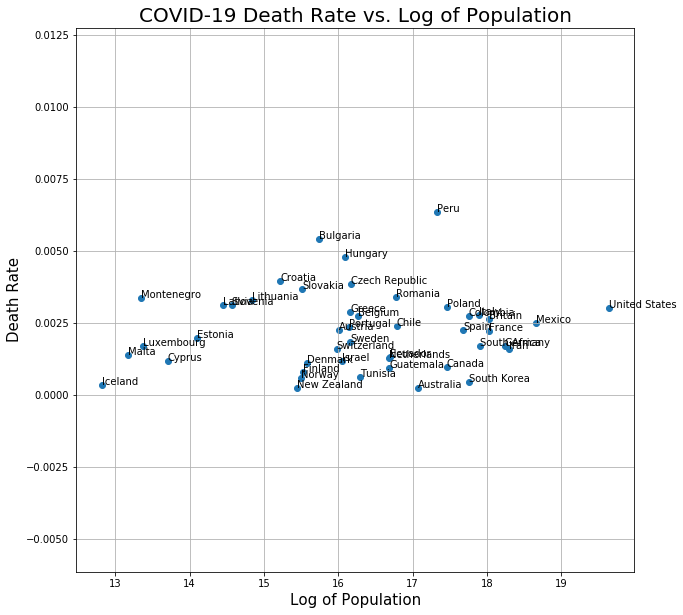

In [16]:
df_country_pd = df_country.toPandas()
df_country_pd['log_population'] = np.log(df_country_pd['population'])
plt.figure(figsize=(10, 10))
plt.scatter(df_country_pd['log_population'], df_country_pd['death_rate'])
for i in range(df_country_pd.shape[0]):
    plt.text(df_country_pd['log_population'].iloc[i], df_country_pd['death_rate'].iloc[i], df_country_pd['country'].iloc[i])
plt.xlabel('Log of Population', fontsize=15)
plt.ylabel('Death Rate', fontsize=15)
plt.title('COVID-19 Death Rate vs. Log of Population', fontsize=20)
plt.grid(True)
plt.show()

In [17]:
df_weekly = df_week.withColumn('start_date', F.to_date(F.col('start_date'), 'yyyy-MM-dd'))
df_weekly = df_weekly.withColumn('end_date', F.to_date(F.col('end_date'), 'yyyy-MM-dd'))
df_weekly = df_weekly.withColumn('year_month', F.date_format('start_date', 'yyyy-MM'))
df_monthly = df_weekly.groupBy('country', 'year_month').agg(F.sum('covid_deaths').alias('monthly_deaths'))
window = Window.partitionBy('country').orderBy(F.desc('monthly_deaths'))
df_max_deaths = df_monthly.withColumn('rank', F.rank().over(window)).filter(F.col('rank') == 1).drop('rank')
df_max_deaths = df_max_deaths.orderBy(F.desc('monthly_deaths'))
df_max_deaths.show()
df_max_deaths.write.format("mongo").mode("overwrite").option("uri", "mongodb://localhost:27018/Project").option("collection", "Project_data").save()

+--------------+----------+--------------+
|       country|year_month|monthly_deaths|
+--------------+----------+--------------+
| United States|   2021-01|         90106|
|       Britain|   2021-01|         37164|
|        Mexico|   2021-01|         31323|
|          Peru|   2021-03|         23925|
|       Germany|   2021-01|         22673|
|         Italy|   2020-11|         21252|
|          Iran|   2021-08|         19678|
|        France|   2020-11|         18173|
|      Colombia|   2021-05|         17484|
|  South Africa|   2021-01|         17005|
|        Poland|   2020-11|         14306|
|         Spain|   2020-03|         12641|
|       Romania|   2021-10|         10207|
|   South Korea|   2022-03|          8357|
|       Hungary|   2021-03|          6741|
|Czech Republic|   2021-03|          6606|
|       Belgium|   2020-04|          6397|
|      Portugal|   2021-01|          5364|
|         Chile|   2020-06|          5254|
|      Bulgaria|   2021-11|          4853|
+----------

In [18]:
df = df.withColumn('date', F.to_date(F.col('date'), 'yyyy-MM-dd'))
df_202101 = df.withColumn('year_month', F.date_format('date', 'yyyy-MM'))
df_jan_2021 = df_202101.filter((F.year('date') == 2021) & (F.month('date') == 1))
total_deaths_jan_2021 = df_jan_2021.agg(F.sum('deaths').alias('total_deaths')).collect()[0]['total_deaths']
print(f'The total number of deaths in the US in January 2021 was {total_deaths_jan_2021}.')

The total number of deaths in the US in January 2021 was 94916.


In [19]:
df_country_death_ratio = df_week.groupBy('country').agg(F.sum('non_covid_deaths').alias('total_non_covid_deaths'), F.sum('covid_deaths').alias('total_covid_deaths'))
df_country_death_ratio = df_country_death_ratio.withColumn('death_ratio', F.col('total_covid_deaths') / (F.col('total_covid_deaths') + F.col('total_non_covid_deaths')))
df_country_death_ratio = df_country_death_ratio.orderBy(F.desc('death_ratio'))
df_country_death_ratio.show()
df_country_death_ratio.write.format("mongo").mode("overwrite").option("uri", "mongodb://localhost:27018/Project").option("collection", "Project_data").save()

+--------------+----------------------+------------------+-------------------+
|       country|total_non_covid_deaths|total_covid_deaths|        death_ratio|
+--------------+----------------------+------------------+-------------------+
|          Peru|              384299.5|            214421| 0.3581320499298086|
|      Colombia|              679902.0|            140202| 0.1709563665096134|
|    Montenegro|               12786.0|              2103|0.14124521458795083|
|         Chile|              290506.0|             46527|0.13804879640866027|
|       Hungary|              311686.0|             46547|0.12993498644736806|
|      Slovakia|              136475.0|             20041|0.12804441718418563|
|        Mexico|             2185830.0|            317420|0.12680315589733346|
|Czech Republic|              279824.0|             40311|0.12591875302606712|
| United States|             7395917.0|           1011492|0.12030959835545053|
|      Slovenia|               51468.0|             

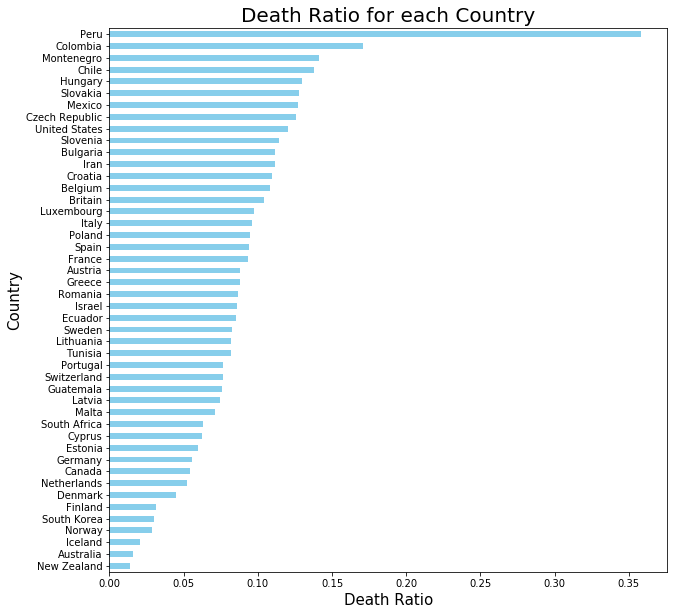

In [20]:
df_country_death_ratio_pd = df_country_death_ratio.toPandas()
df_country_death_ratio_pd.sort_values('death_ratio', ascending=True).plot(kind='barh', x='country', y='death_ratio', legend=False, color='skyblue', figsize=(10, 10))
plt.xlabel('Death Ratio', fontsize=15)
plt.ylabel('Country', fontsize=15)
plt.title('Death Ratio for each Country', fontsize=20)
plt.show()